The real estate dataset containes property sales. Each row is a sale, and the goal of the dataset is to predict the price per unit per area from simple location and neighbourhood features.

Step 1: Imports, loading & cleaning the data

When the dataset is loaded, the code immidately drops the columns unnamed:0 and no, which are just row indices or IDs that do not have any useful or predictive information. Removing them prevents data leakage and makes sure that the model only has meaningful features to work with.

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


#load dataset and dropping unstable columns
df = pd.read_csv("C:\\Users\\gumas\\OneDrive\\Skrivebord\\Dataingenior\\Programmer\\Visual Studio Code\\Mandatory assignment 1\\data\\realestate.csv").drop(columns=["Unnamed: 0", "No"], errors="ignore")

target_col = "Y house price of unit area"
X = df.drop(columns=[target_col])
y = df[target_col]

print("Shape after cleaning:", df.shape)
print("Features:", list(X.columns))
print("Target:", target_col)



Shape after cleaning: (414, 7)
Features: ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
Target: Y house price of unit area


Step 2: train/test split

Regarding the split, I used a 80/20 train-test split, which is deemed a common standard because it provides enought data not only for training, but also hyperparameter tuning while also leaving a sufficiently large 20% testing set for final evaluation. This balance helps reduce overfitting, while still giving a reliable estimate of model performance on unseen data.

The split was done with random sampling (shuffle=True) to avoid any ordering bias, for example if the rows are sorted by date or price. A fixed random_state was used to make the split reproducible, ensuring that results stay consistent across different runs and can be fairly compared or repeated.

Step 2: train/test split & preprocessing setup

In [ ]:
# 80/20 random sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

# preprocessing for linear regressio, imputation and standardization
numeric_features = X.columns
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features)
])

# Cross-validation config
cv = KFold(n_splits=5, shuffle=True, random_state=42)


Train size: (331, 6)  Test size: (83, 6)


Step 3: cross validation for linear regression

This code builds a pipeline that first applies preprocessing (median imputation and standardization) and then fits a LinearRegression model. It evaluates the model using 5-fold cross-validation with R^2 as the metric to estimate how well it generalizes. After checking the mean CV score, it trains the final linear regression model on the entire training set. I did this similarly to the previous Breast Cancer Classifier task, but here the model is for regression and uses R^2 instead of F1-score as the evaluation metric

In [ ]:
# build pipeline with preprocessing + LinearRegression
lin_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

# 5-fold cv to check R²
scores = cross_val_score(lin_pipe, X_train, y_train, cv=cv, scoring="r2")
print(f"Linear Regression CV R² mean: {scores.mean():.4f} (std: {scores.std():.4f})")

# Fit the model on the entire training set
best_linear = lin_pipe.fit(X_train, y_train)


Linear Regression CV R² mean: 0.5478 (std: 0.0997)


Step 5: manual hyperparameter tuning for decision tree

This code performs a manual hyperparameter tuning for the decisionTreeRegressor. It loops through the combinations of max_dept, min_samples_split and min_samples_leaf, while using cross validation as the scoring metric. It then gets stored in the mean scores in dataframe and selects the best performing combination. In the end, it retrains the decision tree with the optimal parameters on the full training set.

I used the same approach as in the Classifiers for Breast Cancer Prediction task, but here the model is a regressor instead of a classifier, and the scoring metric is R^2 rather than F1-score.

In [ ]:
dt_results = []
for max_depth in [3, 4, 5, 6, 8, None]:
    for min_split in [2, 5, 10]:
        for min_leaf in [1, 2, 4]:
            dt = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
                random_state=42
            )
            scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring="r2")
            dt_results.append({
                "max_depth": max_depth,
                "min_samples_split": min_split,
                "min_samples_leaf": min_leaf,
                "cv_r2_mean": scores.mean(),
                "cv_r2_std": scores.std()
            })

dt_results_df = pd.DataFrame(dt_results).sort_values("cv_r2_mean", ascending=False)
display(dt_results_df.head(10))  # top 10  highest configs

best_tree_params = dt_results_df.iloc[0]
max_depth = None if pd.isna(best_tree_params["max_depth"]) else int(best_tree_params["max_depth"])
best_tree = DecisionTreeRegressor(
    max_depth=max_depth,
    min_samples_split=int(best_tree_params["min_samples_split"]),
    min_samples_leaf=int(best_tree_params["min_samples_leaf"]),
    random_state=42
)
best_tree.fit(X_train, y_train)


,max_depth,min_samples_split,min_samples_leaf,cv_r2_mean,cv_r2_std
5,3.0,5,4,0.638937,0.102873
2,3.0,2,4,0.638937,0.102873
8,3.0,10,4,0.638937,0.102873
17,4.0,10,4,0.610115,0.101325
11,4.0,2,4,0.609448,0.100709
14,4.0,5,4,0.609448,0.100709
26,5.0,10,4,0.595727,0.089900
20,5.0,2,4,0.591538,0.089723
23,5.0,5,4,0.591538,0.089723
35,6.0,10,4,0.589574,0.087614


,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


step 6: evaluation and comparing

,model,r2,mae,mse
1,Decision Tree,0.754418,4.733525,41.198745
0,Linear Regression,0.681078,5.305233,53.502252


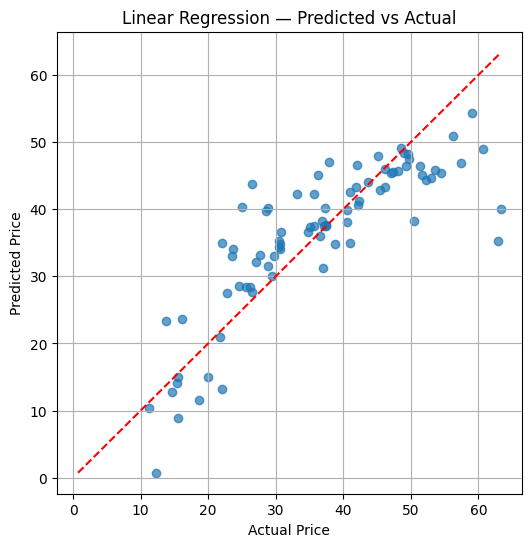

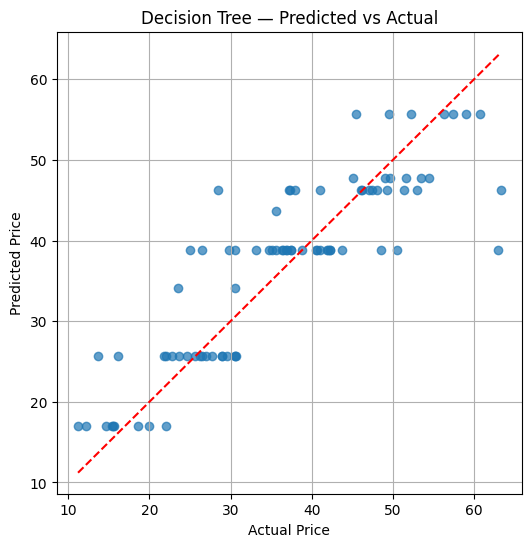

In [22]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    return {
        "model": name,
        "r2": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
        "y_pred": y_pred
    }

results = [
    evaluate(best_linear, "Linear Regression"),
    evaluate(best_tree, "Decision Tree")
]

results_df = pd.DataFrame([{k:v for k,v in r.items() if k!="y_pred"} for r in results]).sort_values("r2", ascending=False)
display(results_df)

# Scatter plots: predicted vs actual
for r in results:
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, r["y_pred"], alpha=0.7)
    lims = [min(y_test.min(), r["y_pred"].min()), max(y_test.max(), r["y_pred"].max())]
    plt.plot(lims, lims, "r--")
    plt.title(f"{r['model']} — Predicted vs Actual")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.grid(True)
    plt.show()


**Discussing the results**

The results show that the decision tree regressor ourpreformed the linear regression across all of the metrics I used. It had a higher R^2, which means that it explained more of the variance in house prices, and also produced lower errors (MAE and MSE)

This shows that the relationships between the input features and the target feature is non linear, and benefits from the flexibility of the decision tree. Linear regression assumes a linear relationship was not equally capable of capturing these patterns. Having a lower MAE and MSE for the tree confir that the predictions are closer to the actual prices, making it a better tree for this particular model.